In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression


In [3]:
#models

import joblib
import pickle

#error handling
try:
    pipeline_object = joblib.load('../models/hmm_multilabel_pipeline.joblib')
    pickle_file = 'hmm_multilabel_pipeline.pkl'

    with open(pickle_file, 'wb') as pkl_file:
        pickle.dump(pipeline_object, pkl_file)
except FileNotFoundError:
    print(f"Error: The file '../../models/hmm_multilabel_pipeline.joblib' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")


rf_model_best = joblib.load('../models/best_rf_model.pkl')
gbdt_model_best = joblib.load('../models/best_gbdt_model.pkl')
log_reg_model = joblib.load('../models/logistic_regression.pkl')


In [28]:
hmm_model = joblib.load('../models/hmm_multilabel_pipeline.pkl')
type(hmm_model)


dict

In [15]:
#saving data
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')



# y_train.columns
y_train = y_train.drop('Unnamed: 0',axis = 1)
y_test = y_test.drop('Unnamed: 0',axis = 1)

In [5]:

base_estimators = [
    ('gbdt',gbdt_model_best),
    ('rf',rf_model_best)
    # ('log reg',log_reg_model)
    # ('hmm model',hmm_model)
]


from sklearn.multiclass import OneVsRestClassifier

stacking = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(max_iter=2000),
    passthrough=True
)

multi_label_stacking = OneVsRestClassifier(stacking)


multi_label_stacking

,estimator,StackingClass...sthrough=True)
,n_jobs,None
,verbose,0
,loss,'log_loss'
,learning_rate,0.2
,n_estimators,200
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


In [6]:
#training our stacked classifier 

multi_label_stacking.fit(X_train, y_train)

# y_train.shape

c:\Users\meron\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\meron\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://s

,estimator,StackingClass...sthrough=True)
,n_jobs,None
,verbose,0
,loss,'log_loss'
,learning_rate,0.2
,n_estimators,200
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


In [7]:
y_pred = multi_label_stacking.predict(X_test)
y_prob = multi_label_stacking.predict_proba(X_test)


In [17]:
#Getting Accuracy score
from sklearn.metrics import accuracy_score

subset_acc = accuracy_score(y_test, y_pred)
print(f"Subset accuracy: {subset_acc:.4f}")


Subset accuracy: 0.5097


In [18]:
#Classification report of ensemble model
from sklearn.metrics import classification_report

label_names = y_test.columns
print(classification_report(y_test, y_pred, target_names=label_names))


              precision    recall  f1-score   support

          AS       0.78      0.66      0.72       104
          AR       0.82      0.63      0.71       114
          MR       0.80      0.53      0.64        90
          MS       0.82      0.71      0.76        85
           N       0.98      0.93      0.95        45

   micro avg       0.82      0.66      0.74       438
   macro avg       0.84      0.69      0.76       438
weighted avg       0.82      0.66      0.73       438
 samples avg       0.75      0.70      0.70       438



c:\Users\meron\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [19]:
#Hamming Loss
from sklearn.metrics import hamming_loss

hloss = hamming_loss(y_test, y_pred)
print(f"Hamming loss: {hloss:.4f}")


Hamming loss: 0.1614


In [20]:
#F1 scores
from sklearn.metrics import f1_score

micro_f1 = f1_score(y_test, y_pred, average="micro")
macro_f1 = f1_score(y_test, y_pred, average="macro")

print(f"Micro F1 score: {micro_f1:.4f}")
print(f"Macro F1 score: {macro_f1:.4f}")


Micro F1 score: 0.7358
Macro F1 score: 0.7564


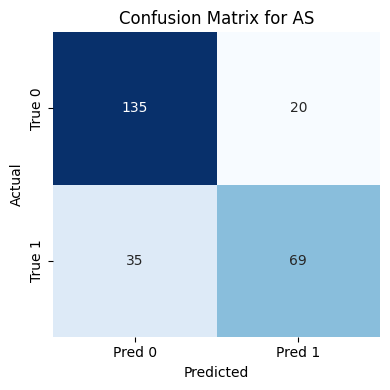

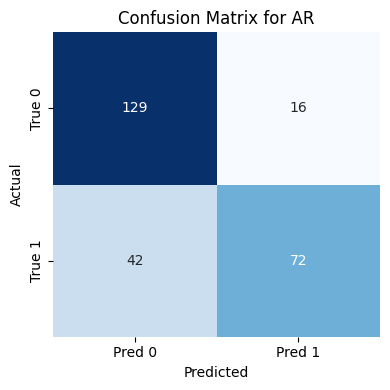

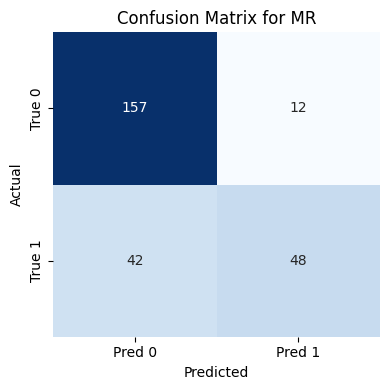

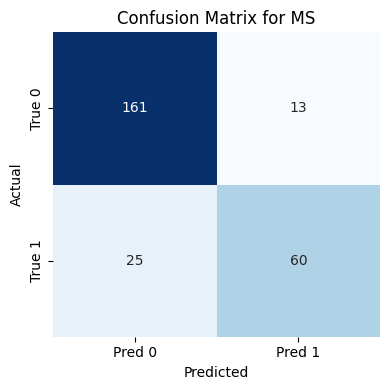

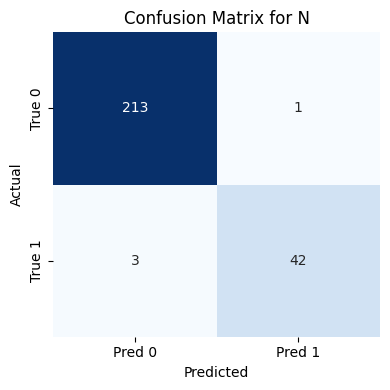

In [31]:
#Visualizing Ensemble Model's Performance

from sklearn.metrics import multilabel_confusion_matrix

# Generate the confusion matrices
conf_matrices = multilabel_confusion_matrix(y_test, y_pred)

for i, cm in enumerate(conf_matrices):
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title(f'Confusion Matrix for {label_names[i]}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()



In [29]:
from sklearn.metrics import roc_curve, auc

for i in range(y_test.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Label {i}')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


InvalidIndexError: (slice(None, None, None), 0)

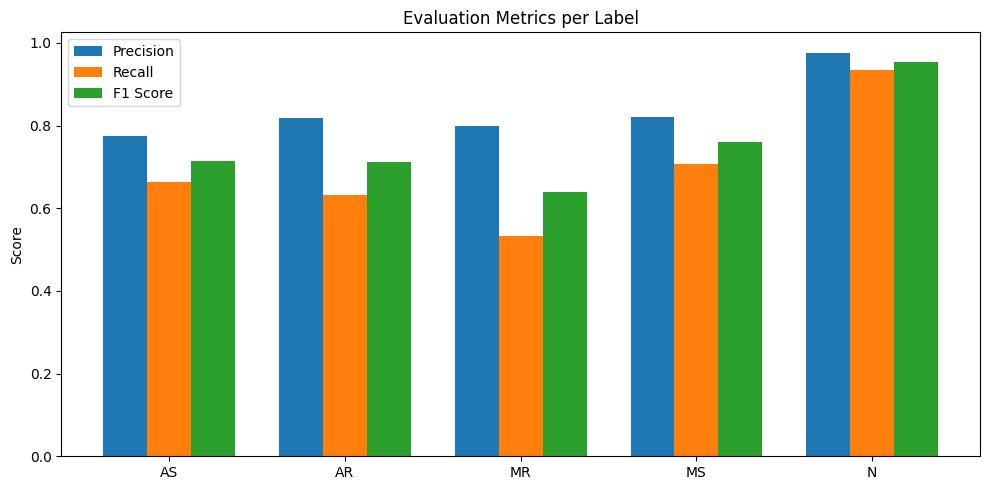

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

labels = y_test.columns

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 5))

plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1 Score')

plt.xticks(x, labels)
plt.ylabel('Score')
plt.title('Evaluation Metrics per Label')
plt.legend()
plt.tight_layout()
plt.show()


In [38]:

import pickle

filename = 'final_stacked_classifier_model.pkl'

with open(filename, 'wb') as file:
    pickle.dump(gbdt_model_best, file)